# Training on Speech Commands

If you havent installed fastaudio do it uncommenting and executing the following cell

In [1]:
#!pip install git+https://github.com/fastaudio/fastaudio.git

In [2]:
from fastai.torch_basics import *
from fastai.basics import *
from fastai.data.all import *
from fastai.callback.all import *
from fastai.vision.all import *

from fastaudio.core.all import *
from fastaudio.augment.all import *

import torchaudio

## Baseline

The dataset is about 2.26 G

In [3]:
r = torchaudio.datasets.SPEECHCOMMANDS(".", download=True)
r

In [4]:
commands_path = Path("SpeechCommands")
audio_files = get_audio_files(commands_path)
len(audio_files)

105835

In [5]:
for i in range(10):
    print(random.choice(audio_files))

SpeechCommands/speech_commands_v0.02/down/61abbf52_nohash_0.wav
SpeechCommands/speech_commands_v0.02/three/773e26f7_nohash_2.wav
SpeechCommands/speech_commands_v0.02/dog/73f20b00_nohash_0.wav
SpeechCommands/speech_commands_v0.02/nine/72242187_nohash_0.wav
SpeechCommands/speech_commands_v0.02/forward/3b195250_nohash_4.wav
SpeechCommands/speech_commands_v0.02/eight/6ef407da_nohash_3.wav
SpeechCommands/speech_commands_v0.02/go/4bc2c2c5_nohash_0.wav
SpeechCommands/speech_commands_v0.02/three/c2d15ea5_nohash_0.wav
SpeechCommands/speech_commands_v0.02/eight/a7200079_nohash_1.wav
SpeechCommands/speech_commands_v0.02/down/3b195250_nohash_1.wav


In [6]:
for i in range(10):
    f = random.choice(audio_files)
    print("File:",f )
    print("Label:", parent_label(f))

File: SpeechCommands/speech_commands_v0.02/eight/ff2b842e_nohash_2.wav
Label: eight
File: SpeechCommands/speech_commands_v0.02/left/20a0d54b_nohash_0.wav
Label: left
File: SpeechCommands/speech_commands_v0.02/one/e2008f39_nohash_0.wav
Label: one
File: SpeechCommands/speech_commands_v0.02/visual/3a3ee7ed_nohash_0.wav
Label: visual
File: SpeechCommands/speech_commands_v0.02/go/4a1e736b_nohash_2.wav
Label: go
File: SpeechCommands/speech_commands_v0.02/visual/72242187_nohash_0.wav
Label: visual
File: SpeechCommands/speech_commands_v0.02/dog/833a0279_nohash_0.wav
Label: dog
File: SpeechCommands/speech_commands_v0.02/off/563aa4e6_nohash_2.wav
Label: off
File: SpeechCommands/speech_commands_v0.02/bird/e102119e_nohash_0.wav
Label: bird
File: SpeechCommands/speech_commands_v0.02/five/c39703ec_nohash_0.wav
Label: five


In [7]:
DBMelSpec = SpectrogramTransformer(mel=True, to_db=True)
a2s = DBMelSpec()
crop_4000ms = CropSignal(4000)
tfms = [crop_4000ms, a2s]

In [8]:
auds = DataBlock(blocks=(AudioBlock, CategoryBlock),  
                 get_items=get_audio_files, 
                 splitter=RandomSplitter(),
                 item_tfms=tfms,
                 get_y=parent_label)

In [9]:
audio_dbunch = auds.dataloaders(commands_path, item_tfms=tfms, bs=64)

In [10]:
# credit to Kevin Bird and Hiromi Suenaga for these two lines to adjust a CNN model to take 1 channel input
def alter_learner(learn, channels=1):
    learn.model[0][0].in_channels=channels
    learn.model[0][0].weight = torch.nn.parameter.Parameter(learn.model[0][0].weight[:,1,:,:].unsqueeze(1))

In [11]:
learn = Learner(audio_dbunch, 
                xresnet18(),
                torch.nn.CrossEntropyLoss(), 
                metrics=[accuracy])
nchannels = audio_dbunch.one_batch()[0].shape[1]
alter_learner(learn, nchannels)

SuggestedLRs(lr_min=0.06309573650360108, lr_steep=0.0020892962347716093)

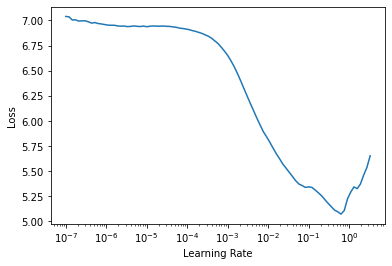

In [12]:
learn.lr_find()

In [13]:
learn.fit_one_cycle(5, lr_max=slice(1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,0.656395,4.380031,0.299334,02:03
1,0.363153,0.380459,0.886852,02:00
2,0.252141,0.366696,0.890773,01:43
3,0.166282,0.195533,0.940993,01:40
4,0.117679,0.169219,0.950300,01:39


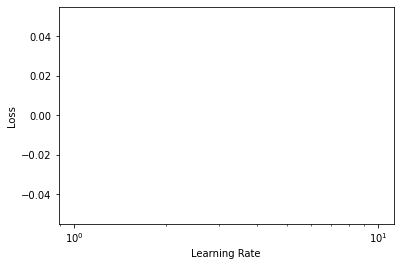

In [14]:
learn.lr_find()

In [15]:
learn.unfreeze()
learn.fit_one_cycle(5, lr_max=slice(1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.108651,0.177195,0.948930,01:39
1,0.106599,0.174635,0.949119,01:36
2,0.100905,0.173525,0.951528,01:46
3,0.090713,0.168025,0.953182,01:50
4,0.081791,0.169523,0.954363,01:45


## Customize our AudioToSpec Function using a config

In [16]:
voice_cfg = AudioConfig.Voice()
a2s = AudioToSpec.from_cfg(voice_cfg)
tfms = [crop_4000ms, a2s]
auds.item_tfms = tfms
# tfms = Pipeline([CropSignal(4000),  a2s, MaskFreq(size=12), MaskTime(size=15), SGRoll()], as_item=True)
dbunch250B = auds.dataloaders(commands_path, bs=64)

In [17]:
learn = Learner(dbunch250B, 
                xresnet18(),
                torch.nn.CrossEntropyLoss(), 
                metrics=[accuracy])
nchannels = dbunch250B.one_batch()[0].shape[1]
alter_learner(learn, nchannels)

SuggestedLRs(lr_min=0.07585775852203369, lr_steep=0.002511886414140463)

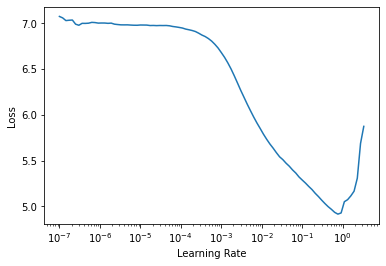

In [18]:
learn.lr_find()

In [19]:
# Better results even without fine tuning, but much slower. We need to move a2s to the GPU and 
# then add data augmentation!
learn.fit_one_cycle(5, lr_max=slice(2e-2))

epoch,train_loss,valid_loss,accuracy,time
0,0.513826,0.857900,0.741343,04:42
1,0.278715,0.291171,0.912883,04:34
2,0.185014,0.192646,0.943119,04:33
3,0.136495,0.140570,0.957481,04:35
4,0.076968,0.124036,0.964048,04:36


## Training an MFCC with Delta

In [20]:
# only grab 1500ms of the clip, voice identity can be done with shorter sections and it will speed it up
# this is really slow for mfcc, even for 45k files, need to figure out what's going on here. Also the results
# shouldn't be this much worse than melspectrogram
a2mfcc = AudioToMFCC(n_mffc=20, melkwargs={"n_fft":2048, "hop_length":256, "n_mels":128})
tfms = [CropSignal(1500), a2mfcc, Delta()]
auds.item_tfms = tfms
# tfms = Pipeline([CropSignal(4000),  a2s, MaskFreq(size=12), MaskTime(size=15), SGRoll()], as_item=True)
dbunch_mfcc = auds.dataloaders(commands_path, bs=64)

In [21]:
#n_mfcc isn't getting passed down? 
dbunch_mfcc.one_batch()[0].shape

torch.Size([64, 3, 40, 94])

In [22]:
learn = Learner(dbunch_mfcc, 
                xresnet18(),
                torch.nn.CrossEntropyLoss(), 
                metrics=[accuracy])

SuggestedLRs(lr_min=0.15848932266235352, lr_steep=0.00363078061491251)

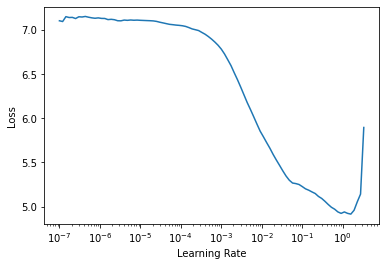

In [23]:
learn.lr_find()

In [24]:
learn.fit_one_cycle(5, lr_max=slice(2e-2))

epoch,train_loss,valid_loss,accuracy,time
0,0.558041,0.821212,0.769027,02:45
1,0.369136,0.475784,0.858553,02:40
2,0.275744,0.333747,0.899891,02:44
3,0.168651,0.176755,0.946048,02:42
4,0.125728,0.160911,0.952851,02:39


<div class="alert alert-block alert-info">
<strong>From Here:</strong><br>
    1. Get transforms on the GPU <br>
    2. Once it's faster test signal and spectrogram augments for speed/efficacy<br>
    3. Fine-tune and see how high we can push results on 250 speakers
</div>